In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.DataFrame.from_csv("./train.csv")

In [3]:
x_col = [ 'dist','due', 'lat','lon','f_class','s_class','t_class',]
X_raw = data[x_col]
y = data['burned'].values


In [4]:
#Если у вас слабый компьютер - можно взять подвыборку данных
#data = data[::2]

# Простое решение
- Сделаем One-Hot encoding для всех категориальных фичей
- Научим Random Forest

### Предобработка данных

In [5]:
from sklearn.feature_extraction import DictVectorizer

#вытаскиватель категориальных фичей
vectorizer = DictVectorizer(sparse=False,dtype=np.bool)

def preprocess_data(X_raw):
    data_dict = [ {'f_class':f,'s_class':s,'t_class':t}
               for f,s,t in X_raw[['f_class','s_class','t_class']].values ]

    Xcat = vectorizer.fit_transform(data_dict)
    
    real_features = ["dist","lat","lon"]
    Xreal = X_raw[real_features].values
    Xfull = np.concatenate([
            Xreal,
            Xcat            
        ],axis=1)
    
    return pd.DataFrame(Xfull,columns=real_features+vectorizer.feature_names_)

In [6]:
X = preprocess_data(X_raw)

### Поделим на обучение и валидацию
* Важно, что мы делим не случайно, а по времени:
 * Валидационная выборка вся находится строго раньше тестовой
 * Это вызвано тем, что тестовые данные по времени дальше обучающих

In [7]:

Xtr = X[:1000000]
Xval = X[1000000:]
Ytr = y[:1000000]
Yval = y[1000000:]

### Обучим модель

In [8]:

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=250,n_jobs=-1)


model.fit(Xtr,Ytr)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Оценим качество

train: 	 AUC = 0.98375 	 Accuracy = 0.83367 	 Precision = 0.15670 	 Recall = 0.00983
val: 	 AUC = 0.62322 	 Accuracy = 0.82338 	 Precision = 0.16960 	 Recall = 0.01270


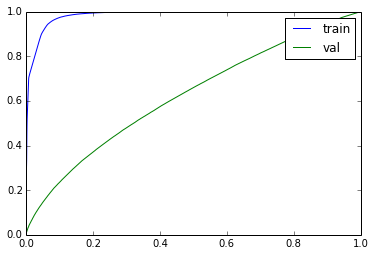

In [9]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_curve


for source_i, Xi,Yi in [
                            ["train",Xtr,Ytr],
                            ["val",Xval,Yval]
                                ]:
    
    # Предскажем вероятность сгорания
    Yi_pred_proba = model.predict_proba(Xi)[:,1]
    
    #Поделим предсказание на сгоревшие и не сгоревшие
    Yi_pred_class = np.argsort(Yi_pred_proba) < 10000
    
    auc = roc_auc_score(Yi,Yi_pred_proba)
    acc = accuracy_score(Yi,Yi_pred_class)
    
    print '%s: \t AUC = %.5f \t Accuracy = %.5f'%(source_i, auc, acc)
    
    fpr,tpr,_ = roc_curve(Yi,Yi_pred_proba)
    
    plt.plot(fpr,tpr,label = source_i)
    
plt.legend()


# Оценим полезность признаков

In [10]:
def plot_forest_feature_importances(rf,feature_names):
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %s (%f)" % (f + 1, feature_names[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    
    plt.yscale("log")
    plt.show()

Feature ranking:
1. dist (0.371182)
2. lat (0.312126)
3. lon (0.311269)
4. f_class (0.000947)
5. f_class=business (0.000795)
6. f_class=econom (0.000571)
7. f_class=vip (0.000565)
8. s_class (0.000531)
9. s_class=business (0.000515)
10. s_class=econom (0.000397)
11. s_class=vip (0.000344)
12. t_class (0.000301)
13. t_class=business (0.000292)
14. t_class=econom (0.000090)
15. t_class=vip (0.000076)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


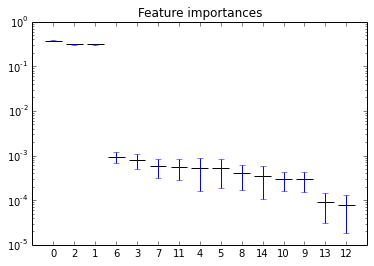

In [11]:
plot_forest_feature_importances(model,X.columns)

# Отгрузим решение в файл

In [12]:
def generate_submission(preproc_fun,model,filename="submission.csv"):
    
    data_eval = pd.DataFrame.from_csv("./evaluation.handout.csv")
    
    
    x_col = [ 'dist','due', 'lat','lon','f_class','s_class','t_class',]
    X_eval = preproc_fun(data_eval[x_col])
    
    # Предскажем вероятность сгорания
    Y_pred_proba_eval = model.predict_proba(X_eval)[:,1]
    
    #Поделим предсказание на сгоревшие и не сгоревшие по порогу (thr)
    
    
    response = pd.DataFrame()
    response["Ids"] = np.arange(len(Y_pred_proba_eval))
    
    response["Y_prob"] = map("{0:.5f}".format,Y_pred_proba_eval)
    
    
    response.to_csv(filename,index=None)

In [13]:
generate_submission(preprocess_data,model,"submission.csv")

# Используем время и внешние данные
* признаки - 
 * день недели (1-7 от понедельника до воскресенья категориальными признаками) 
 * время дня (вещественное число от 0 до 1 - от 00.00 до 23.59)
* абсолютное время не используем т.к. обучение и тест не пересекаются по времени
* отдельно посмотрим список праздников в этом году и сделаем из этого отдельный признак

In [14]:


#вытаскиватель категориальных фичей
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer(sparse=False,dtype=np.bool)

# используем встроенный питоновый парсер времени
from dateutil import parser

def preprocess_with_time(X_raw):

    #распарсим время
    datetimes = list(X_raw.due.apply(lambda x: parser.parse(x)))

    #время дня от 0 до 1
    rel_times = map(lambda dt: (dt.hour*60 + dt.minute)/(24.*60), datetimes)

    #день недели
    week_days = map( lambda x: x.isoweekday() , datetimes)

    rel_times = np.array(rel_times)
    week_days = np.array(week_days)

    
    
    dow_names = ['mon','tue','wed','thu','fri','sat','sun']
    
    data_dict = ( {'f_class':f,'s_class':s,'t_class':t,'day_of_week':dow_names[day_of_week-1]}
               for (f,s,t),day_of_week in zip(X_raw[['f_class','s_class','t_class']].values, week_days) )

    Xcat = vectorizer.fit_transform(data_dict)

    X_raw["time_of_day_rel"] = rel_times
    real_features = ["dist","lat","lon","time_of_day_rel"]
    Xreal = X_raw[real_features].values
    
    
    Xfull = np.concatenate([
            Xreal,
            Xcat            
        ],axis=1)
    
    return pd.DataFrame(Xfull,columns=real_features+vectorizer.feature_names_)




In [16]:
x_col = [ 'dist','due', 'lat','lon','f_class','s_class','t_class',]
X = data[x_col]
y = data['burned'].values

X = preprocess_with_time(X_raw)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
#делим на обучение и тест
Xtr = X[:1000000]
Xval = X[1000000:]
Ytr = y[:1000000]
Yval = y[1000000:]


In [18]:

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,n_jobs=-1,min_samples_split=75,)

model.fit(Xtr,Ytr,)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=75,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Оценим качество модели
* старым методом

train: 	 AUC = 0.89090 	 Accuracy = 0.83371 	 Precision = 0.15850 	 Recall = 0.00994
val: 	 AUC = 0.64725 	 Accuracy = 0.82339 	 Precision = 0.16980 	 Recall = 0.01272


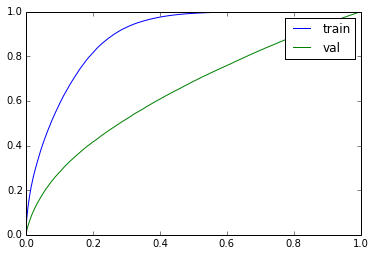

In [19]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_curve


for source_i, Xi,Yi in [
                            ["train",Xtr,Ytr],
                            ["val",Xval,Yval]
                                ]:
    
    # Предскажем вероятность сгорания
    Yi_pred_proba = model.predict_proba(Xi)[:,1]
    
    #Поделим предсказание на сгоревшие и не сгоревшие
    Yi_pred_class = np.argsort(Yi_pred_proba) < 10000
    
    auc = roc_auc_score(Yi,Yi_pred_proba)
    acc = accuracy_score(Yi,Yi_pred_class)
    
    print '%s: \t AUC = %.5f \t Accuracy = %.5f'%(source_i, auc, acc)
    
    fpr,tpr,_ = roc_curve(Yi,Yi_pred_proba)
    
    plt.plot(fpr,tpr,label = source_i)
    
plt.legend()


Feature ranking:
1. dist (0.280710)
2. lat (0.249434)
3. lon (0.246442)
4. time_of_day_rel (0.176713)
5. day_of_week=fri (0.004090)
6. day_of_week=mon (0.003462)
7. day_of_week=sat (0.003235)
8. day_of_week=sun (0.003148)
9. day_of_week=thu (0.003088)
10. day_of_week=tue (0.003058)
11. day_of_week=wed (0.003044)
12. f_class (0.003043)
13. f_class=business (0.002862)
14. f_class=econom (0.002763)
15. f_class=vip (0.002728)
16. s_class (0.002646)
17. s_class=business (0.002328)
18. s_class=econom (0.002130)
19. s_class=vip (0.001600)
20. t_class (0.001379)
21. t_class=business (0.001372)
22. t_class=econom (0.000379)
23. t_class=vip (0.000348)


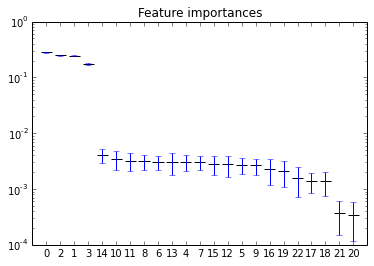

In [20]:
plot_forest_feature_importances(model,X.columns)

In [21]:
#Используем данные о праздниках отсюда - http://eduscan.net/help/calendar2014 http://newslab.ru/article/559455

holidays = "1.01,2.01,3.01,4.01,5.01,6.01,7.01,8.01,"\
"23.02,8.03,9.03,10.03,1.05,2.05,3.05,4.05,9.05,10.05,11.05,12.06,13.06".split(',')

holidays = map(lambda s: tuple(map(int,s.split('.'))),holidays)

#вытаскиватель категориальных фичей
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer(sparse=False,dtype=np.bool)

# используем встроенный питоновый парсер времени
from dateutil import parser

def preprocess_with_holidays(X_raw):

    #распарсим время
    datetimes = list(X_raw.due.apply(lambda x: parser.parse(x)))

    #время дня от 0 до 1
    rel_times = map(lambda dt: (dt.hour*60 + dt.minute)/(24.*60), datetimes)

    #день недели
    week_days = map( lambda x: x.isoweekday() , datetimes)

    rel_times = np.array(rel_times)
    week_days = np.array(week_days)
    
    is_holiday = map(lambda dt: (dt.day,dt.month) in holidays,
                 datetimes)

    
    
    dow_names = ['mon','tue','wed','thu','fri','sat','sun']
    
    data_dict = ( {'f_class':f,'s_class':s,'t_class':t,'day_of_week':dow_names[day_of_week-1]}
               for (f,s,t),day_of_week in zip(X_raw[['f_class','s_class','t_class']].values, week_days) )

    Xcat = vectorizer.fit_transform(data_dict)

    X_raw["time_of_day_rel"] = rel_times
    X_raw["is_holiday"] = is_holiday
    other_features = ["dist","lat","lon","time_of_day_rel","is_holiday"]
    Xreal = X_raw[other_features].values
    
    
    Xfull = np.concatenate([
            Xreal,
            Xcat            
        ],axis=1)
    
    return pd.DataFrame(Xfull,columns=other_features+vectorizer.feature_names_)

In [22]:
#обработаем данные
x_col = [ 'dist','due', 'lat','lon','f_class','s_class','t_class',]
X = data[x_col]
y = data['burned'].values

X = preprocess_with_holidays(X_raw)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
#обучение и тест
Xtr = X[:1000000]
Xval = X[1000000:]
Ytr = y[:1000000]
Yval = y[1000000:]

In [24]:

from sklearn.ensemble import RandomForestClassifier

#Также обучим более "случайную" версию RandomForest
model = RandomForestClassifier(n_estimators=100,n_jobs=-1,min_samples_split=75,min_samples_leaf=20)

model.fit(Xtr,Ytr)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=20, min_samples_split=75,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train: 	 AUC = 0.81084 	 Accuracy = 0.83376
val: 	 AUC = 0.65073 	 Accuracy = 0.82323


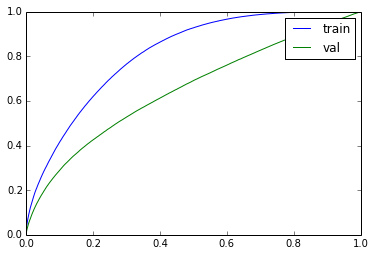

In [28]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_curve


for source_i, Xi,Yi in [
                            ["train",Xtr,Ytr],
                            ["val",Xval,Yval]
                                ]:
    
    # Предскажем вероятность сгорания
    Yi_pred_proba = model.predict_proba(Xi)[:,1]
    
    #Поделим предсказание на сгоревшие и не сгоревшие
    Yi_pred_class = np.argsort(Yi_pred_proba) < 10000
    
    auc = roc_auc_score(Yi,Yi_pred_proba)
    acc = accuracy_score(Yi,Yi_pred_class)
    
    print '%s: \t AUC = %.5f \t Accuracy = %.5f'%(source_i, auc, acc)
    
    fpr,tpr,_ = roc_curve(Yi,Yi_pred_proba)
    
    plt.plot(fpr,tpr,label = source_i)
    
plt.legend()


Feature ranking:
1. dist (0.303759)
2. lat (0.230330)
3. lon (0.227336)
4. time_of_day_rel (0.165272)
5. is_holiday (0.009350)
6. day_of_week=fri (0.005937)
7. day_of_week=mon (0.005621)
8. day_of_week=sat (0.004785)
9. day_of_week=sun (0.004648)
10. day_of_week=thu (0.004598)
11. day_of_week=tue (0.004489)
12. day_of_week=wed (0.004173)
13. f_class (0.003989)
14. f_class=business (0.003802)
15. f_class=econom (0.003620)
16. f_class=vip (0.003603)
17. s_class (0.003274)
18. s_class=business (0.003164)
19. s_class=econom (0.002899)
20. s_class=vip (0.002048)
21. t_class (0.001536)
22. t_class=business (0.001279)
23. t_class=econom (0.000246)
24. t_class=vip (0.000241)


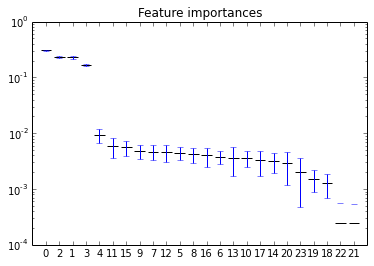

In [26]:
plot_forest_feature_importances(model,X.columns)

In [27]:
generate_submission(preprocess_with_holidays,model,"submission2.csv")

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Советы по улучшению модели:

* Смотри глазами на данные - строй графики, исследуй аномалия 
 * это может принести новые идеи и отбросить нежизнеспособные намного раньше 
 * Туториал по библиотеке, в которой можно строить графики 
   * http://matplotlib.org/users/pyplot_tutorial.html
 * Ключевой вопрос самому себе - __"От чего ещё может зависеть, сгорит ли заказ?"__


* Попробуй более точно настроить модель или выбрать другую
 * Random Forest с текущими параметрами можно улучшить
   * Документация по нему - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
 * А можно использовать другие, более подходящие методы
   * Документация по методам - http://scikit-learn.org/stable/supervised_learning.html
 * Наконец, модели можно комбинировать
   * Например, усреднять с весами
   * В итоге качество может быть лучше, чем у каждой модели по отдельности
 * Важно не увлечься - зачастую качественные изменения решения намного лучше подкручивания параметров


* Подумай, какие ещё дополнительные данные можно провязать с выборкой? 
 * насколько реально применить их за отведённое время?


* __Главное__ - пытайся понять, дадут ли твои улучшения прирост на новых данных
 * Тестовая выборка находится по времени дальше, чем обучающая.
   * Например, нельзя использовать номер дня в году, потому что мы обучаемся на выборке __ДО__ начала контрольной
 * Это не значит, что нужно отправлять миллион решений на проверку и выбирать лучшее - это приведёт к переобучению
 